In [ ]:
#NEW IDEA. PERHAPS FOR EACH FIGHT, WE LOOK AT THE CORRESPONDING POINT IN THE SPACE OF ALL FEATURES, AND THEN
#BUILD A MODEL WHERE THE TRAINING SET ONLY INVOLVES POINTS NEAR THAT POINT.
#THIS MIGHT BE MORE EFFECTIVE BECAUSE THE MOST RELEVANT FEATURES IS LIKELY TO DEPEND ON THE LOCATION
#IN THE PARAMETER SPACE.

In [2]:
#getting dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' (disables SettingWithCopyWarning)

import numpy as npy
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import random
import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools
#this imports all of the functions from the file functions.py
from functions import *

In [3]:
ufc_fights = pd.read_csv('ufc_fights.csv',low_memory=False)

In [4]:
#importing csv fight data and saving as dataframes
ufc_fights_winner = pd.read_csv('ufc_fights.csv',low_memory=False)
ufc_fights_method = pd.read_csv('ufc_fights.csv',low_memory=False)
ufcfighterscrap =pd.read_csv('fighter_stats.csv',sep=',',low_memory=False)

In [5]:
#ages are saved as strings?? Does this affect the model? Lets fix it and see
ufc_fights_winner['fighter_age'][0]

'33'

In [6]:
#there are some issues with how names are saved
#it gets saved as Joanne Wood for some reason
for i in range(len(ufc_fights_winner['fighter'])):
    if ufc_fights_winner['fighter'][i]=='Joanne Wood':
        ufc_fights_winner['fighter'][i]='Joanne Calderwood'
    if ufc_fights_winner['opponent'][i]=='Joanne Wood':
        ufc_fights_winner['opponent'][i]='Joanne Calderwood'

In [7]:
#there are two lists of names which sometimes get scraped differently... this causes some problems which are being
#addressed in this cell. 

names_list = list(set((list(ufcfightscrap['fighter'])+list(ufcfightscrap['opponent']))))
names_list.sort()

names_list2 = list(set(ufcfighterscrap['name']))
names_list2.sort()

#Use the following two lines of code to examine names if necessary...

#for name in names_list:
    #print(name)
    
#for name in names_list2:
    #print(name)

In [8]:
#assumes first and last name
def swap_name(name):
    first_name=''
    last_name=''
    for i in range(len(name)):
        if name[i]==' ':
            first_name += name[0:i]
            last_name += name[i+1:]
            break
    return last_name+' '+first_name

swap_name('Xiaonan Yan')

'Yan Xiaonan'

In [9]:
#this finds all names in ufcfightscrap which are sometimes written in the wrong order 
#e.g. ('Weili Zhang', 'Zhang Weili')
names = [name for name in ufcfightscrap['fighter']]
opponent_names = [name for name in ufcfightscrap['opponent']]
names.extend(opponent_names)
names_swapped = [swap_name(name) for name in names]
errors=[name for name in names if name in names_swapped]
names_to_fix = list(set(errors))
pairs = [[name,swap_name(name)] for name in names_to_fix]
sorted_pairs = []
for pair in pairs:
    pair.sort()
    sorted_pairs.append(tuple(pair))
error_pairs = list(set(sorted_pairs))
error_pairs

[]

In [10]:
#fixing all swapped names
#setting name so that first name is before last name in lex order
for i in range(len(ufcfightscrap['fighter'])):
    for pair in error_pairs:
        if ufcfightscrap['fighter'][i]==pair[0] or ufcfightscrap['fighter'][i]==pair[1]:
            ufcfightscrap['fighter'][i]=pair[0] 
        if ufcfightscrap['opponent'][i]==pair[0] or ufcfightscrap['opponent'][i]==pair[1]:
            ufcfightscrap['opponent'][i]=pair[0] 

In [11]:
#cleaning the methods column for winner prediction 
#changing anything other than 'U-DEC','M-DEC', 'KO/TKO', 'SUB', to 'bullshit'
#changing 'U-DEC','M-DEC', to 'DEC'
#(counting split decisions as bullshit)
ufc_fights_winner['method'] = clean_method_for_winner_vect(ufc_fights_winner['method'])
ufc_fights_winner['method'].unique()

array(['SUB', 'KO/TKO', 'DEC', 'bullshit'], dtype=object)

In [12]:
#cleaning the methods column for method prediction 
#changing anything other than 'U-DEC','M-DEC', 'S-DEC', 'KO/TKO', 'SUB', to 'bullshit'
#changing 'U-DEC','M-DEC', 'S-DEC', to 'DEC'
#(counting split decisions as decisions)
ufc_fights_method['method'] = clean_method_vect(ufc_fights_method['method'])
ufc_fights_method['method'].unique()

array(['SUB', 'KO/TKO', 'DEC', 'bullshit'], dtype=object)

In [13]:
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights_winner['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no split decision or DQ or Overturned or anything else like that)
method_mask_winner=(ufc_fights_winner['method']!='bullshit')
method_mask_method=(ufc_fights_method['method']!='bullshit')
#fights where age is known
age_mask=(ufc_fights_winner['fighter_age']!='unknown')&(ufc_fights_winner['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights_winner['fighter_height']!='unknown')&(ufc_fights_winner['opponent_height']!='unknown')
reach_mask=(ufc_fights_winner['fighter_reach']!='unknown')&(ufc_fights_winner['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights_winner['fighter_wins'] != 'unknown' )& (ufc_fights_winner['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights_winner['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights_winner['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights_winner=ufc_fights_winner[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights_method=ufc_fights_method[draw_mask&method_mask_method&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights=ufc_fights[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

#listing all stats and making some new stats from them (differences often score higher in the learning models)
record_statistics=[u'fighter_wins', 
                   u'fighter_losses',
                   u'fighter_L5Y_wins',
                   u'fighter_L5Y_losses', 
                   u'fighter_L2Y_wins', 
                   u'fighter_L2Y_losses',
                    u'fighter_ko_wins',
                   u'fighter_ko_losses',
                   u'fighter_L5Y_ko_wins',
                   u'fighter_L5Y_ko_losses',
                   u'fighter_L2Y_ko_wins',
                    u'fighter_L2Y_ko_losses',
                   u'fighter_sub_wins',
                   u'fighter_sub_losses',
                   u'fighter_L5Y_sub_wins',
                    u'fighter_L5Y_sub_losses', 
                   u'fighter_L2Y_sub_wins', 
                   u'fighter_L2Y_sub_losses',
                   u'opponent_wins', 
                   u'opponent_losses',
                   u'opponent_L5Y_wins', 
                   u'opponent_L5Y_losses', 
                   u'opponent_L2Y_wins', 
                   u'opponent_L2Y_losses', 
                    u'opponent_ko_wins', 
                   u'opponent_ko_losses', 
                   u'opponent_L5Y_ko_wins', 
                   u'opponent_L5Y_ko_losses', 
                   u'opponent_L2Y_ko_wins',
                    u'opponent_L2Y_ko_losses', 
                   u'opponent_sub_wins', 
                   u'opponent_sub_losses',
                   u'opponent_L5Y_sub_wins', 
                    u'opponent_L5Y_sub_losses', 
                   u'opponent_L2Y_sub_wins', 
                   u'opponent_L2Y_sub_losses']

physical_stats=[ u'fighter_age',
                u'fighter_height',
                    u'fighter_reach',  
                u'opponent_age',  
                u'opponent_height',
                    u'opponent_reach']

#THERE MAY BE A PROBLEM IN AGE HEIGHT REACH TO DO WITH STRING VS FLOAT. MAKE SURE THESE ARE ALL THE CORRECT TYPE
#MAYBE WE ARE LOSING PREDICTABILITY HERE

#here is the list of all stats available (besides stance), does not include names or result
punch_statistics=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                    
                    u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg']

#here is the version of punch stats geared for comparing fighter_inf to opponent_abs
punch_statistics_alt=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg',
                     
                     u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg']

#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[record_statistics[i]+'_diff_2']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+half_length]]
    ufc_fights_method[record_statistics[i]+'_diff_2']=ufc_fights_method[record_statistics[i]]-ufc_fights_method[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights_winner['height_diff']=ufc_fights_winner['fighter_height'].apply(float)-ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['reach_diff']=ufc_fights_winner['fighter_reach'].apply(float)-ufc_fights_winner['opponent_reach'].apply(float)
ufc_fights_method['height_diff']=ufc_fights_method['fighter_height'].apply(float)-ufc_fights_method['opponent_height'].apply(float)
ufc_fights_method['reach_diff']=ufc_fights_method['fighter_reach'].apply(float)-ufc_fights_method['opponent_reach'].apply(float)


physical_stats_diff = ['fighter_age_diff', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights_method[punch_statistics[i]+'_diff_2']=ufc_fights_method[punch_statistics[i]]-ufc_fights_method[punch_statistics[i+half_length]]
    ufc_fights_winner[punch_statistics[i]+'_diff_2']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
possible_stats =record_statistics_diff+physical_stats_diff+punch_statistics_diff



In [14]:
ufc_fights_method['method'].unique()

array(['SUB', 'KO/TKO', 'DEC'], dtype=object)

In [15]:
ufc_fights_method['result'].unique()

array(['L', 'W'], dtype=object)

In [16]:
ufc_fights_winner['method'].unique()

array(['SUB', 'KO/TKO', 'DEC'], dtype=object)

In [17]:
ufc_fights_winner['result'].unique()

array(['L', 'W'], dtype=object)

In [18]:
ufc_fights['result'].unique()

array(['L', 'W'], dtype=object)

In [19]:
ages = ufc_fights_winner['fighter_age'].unique()
ages.sort()
ages

array(['19', '20', '21', '21.0', '22', '23', '23.0', '24', '24.0', '25',
       '25.0', '26', '26.0', '27', '27.0', '28', '28.0', '29', '29.0',
       '30', '30.0', '31', '31.0', '32', '32.0', '33', '33.0', '34',
       '34.0', '35', '35.0', '36', '36.0', '37', '37.0', '38', '38.0',
       '39', '39.0', '40', '40.0', '41', '41.0', '42', '43', '43.0', '44',
       '44.0', '45', '45.0', '47'], dtype=object)

In [20]:
#setting 
ufc_fights_winner['fighter_age'] = ufc_fights_winner['fighter_age'].apply(float)
ufc_fights_winner['opponent_age'] = ufc_fights_winner['opponent_age'].apply(float)
ufc_fights_method['fighter_age'] = ufc_fights_method['fighter_age'].apply(float)
ufc_fights_method['opponent_age'] = ufc_fights_method['opponent_age'].apply(float)
ufc_fights_winner['fighter_age_diff'] = ufc_fights_winner['fighter_age']-ufc_fights_winner['opponent_age']

ufc_fights['fighter_age'] = ufc_fights['fighter_age'].apply(float)
ufc_fights['opponent_age'] = ufc_fights['fighter_age'].apply(float)
ufc_fights['fighter_age_diff'] = ufc_fights['fighter_age']-ufc_fights['opponent_age']


In [21]:
#lets see if data type affects performance 
ufc_fights_winner['fighter_age_diff'] = ufc_fights_winner['fighter_age_diff'].apply(float)


In [22]:
ages = ufc_fights_winner['fighter_age'].unique()
ages.sort()
ages

array([19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31.,
       32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
       45., 47.])

In [26]:
#this is currently the highest scoring subset of stats to choose. It scores around .637. 
#dropped to ,.617 after I changed the age columns to be floats instead of strings... this is VERY strange...
#actually, after I changed method mask to coincide with the method prediction notebook, it dropped a whole percentage
#to .626... Why would this be?
#FIGURED IT OUT. Including split decisions in the example set drops predictions by a whole percentage. I changed the
#clean_method function to count split decisions as 'bullshit'
#This is the score to beat.

best_smallest_set=list(set(['fighter_age_diff', 
                            'reach_diff', 
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_L2Y_wins_diff_2', 
                            'fighter_L5Y_wins_diff_2', 
                            'fighter_L5Y_sub_wins_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_head_strikes_landed_avg_diff_2', 
                            'fighter_inf_leg_strikes_landed_avg_diff_2', 
                            'fighter_abs_head_strikes_landed_avg_diff_2', 
                            'fighter_inf_knockdowns_avg_diff_2', 
                            'fighter_inf_clinch_strikes_attempts_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_inf_ground_strikes_landed_avg_diff_2', 
                            'fighter_inf_sig_strikes_landed_avg_diff_2'
]))

ufc_fights_df = ufc_fights_winner[best_smallest_set]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(cross_val_score(winPredictionModel,X,y,cv=3).mean()))



model score: 0.6395454545454545
cross val score: 0.6336382774929897


In [23]:
#random forest does way better for picking the method!
best_stats=['fighter_ko_losses_diff_2', 'fighter_L2Y_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300]
yr=ufc_fights_method['method'].iloc[0:2300]

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

Accuracy: 0.5165264733348992 F1 score: 0.20710193522299952


In [29]:
#I've defined this in such a way to predict what happens when fighter1 in their day1 version fights fighter2
#in their day2 version. Meaning we could compare for example 2014 Tyron Woodley to 2019 Colby Covington
def ufc_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [fighter_age(fighter1,day1)-fighter_age(fighter2,day2),
            fighter_reach(fighter1)-fighter_reach(fighter2),
            L5Y_ko_losses(fighter1,day1)-L5Y_ko_losses(fighter2,day2),
            L5Y_losses(fighter1,day1)-L5Y_losses(fighter2,day2),
            L2Y_wins(fighter1,day1)-L2Y_wins(fighter2,day2),
            L5Y_wins(fighter1,day1)-L5Y_wins(fighter2,day2),
            L5Y_sub_wins(fighter1,day1)-L5Y_sub_wins(fighter2,day2),
            avg_count('total_strikes_landed',fighter1,'abs',day1)-avg_count('total_strikes_landed',fighter2,'abs',day2),
            avg_count('head_strikes_landed',fighter1,'inf',day1)-avg_count('head_strikes_landed',fighter2,'inf',day2),
            avg_count('leg_strikes_landed',fighter1,'inf',day1)-avg_count('leg_strikes_landed',fighter2,'inf',day2),
            avg_count('head_strikes_landed',fighter1,'abs',day1)-avg_count('head_strikes_landed',fighter2,'abs',day2),
            avg_count('knockdowns',fighter1,'inf',day1)-avg_count('knockdowns',fighter2,'inf',day2),
            avg_count('clinch_strikes_attempts',fighter1,'inf',day1)-avg_count('clinch_strikes_attempts',fighter2,'inf',day2),
            avg_count('takedowns_attempts',fighter1,'inf',day1)-avg_count('takedowns_attempts',fighter2,'inf',day2),
            avg_count('ground_strikes_landed',fighter1,'inf',day1)-avg_count('ground_strikes_landed',fighter2,'inf',day2),
            avg_count('sig_strikes_landed',fighter1,'inf',day1)-avg_count('sig_strikes_landed',fighter2,'inf',day2)
           ]


def ufc_method_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [ko_losses(fighter1,day1)-ko_losses(fighter2,day2),
            sub_losses(fighter1,day1)-sub_losses(fighter2,day2)]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
print('coefficients'+str(winPredictionModel.coef_))
print('intercept'+str(winPredictionModel.intercept_))

best_stats=['fighter_ko_losses_diff_2', 'fighter_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300].to_numpy()
yr=ufc_fights_method['method'].iloc[0:2300]
rfc.fit(Xr,yr)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#date entered in the form 'Aug 20, 2013'
#predicts what happens if the day1 version of fighter1 fights fighter2 at their day2 version
#by default day1 and day2 are set to today if left unspecified
def ufc_predict(fighter1,fighter2,day1=date.today(), day2=date.today()):
    fighters=[fighter1,fighter2]
    random_guy=fighters[random.choice([0,1])]
    fighter1_fights=(ufcfightscrap['fighter']==fighter1).sum()
    fighter2_fights=(ufcfightscrap['fighter']==fighter2).sum()
    if fighter1_fights==0 and not fighter2_fights==0:
        print('This is '+fighter1+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    elif fighter2_fights==0 and not fighter1_fights==0:
        print('This is '+fighter2+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.') 
    elif fighter1_fights==0 and fighter2_fights==0:
        print('This is both '+fighter1+"'s "+'and '+fighter2+"'s "+"UFC debuts... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    else:
        try:
            print('The winner is...')
            ufc_tuple=ufc_prediction_tuple(fighter1,fighter2,day1,day2)
            ufc_method_tuple=ufc_method_prediction_tuple(fighter1,fighter2,day1,day2)
            value=winPredictionModel.predict([ufc_tuple])[0]
            result=rfc.predict([ufc_method_tuple])[0]
            if fighter1=="Jon Jones" and fighter2=="Jon Jones":
                print('Daniel Cormier')
            elif value=='W':
                print(fighter1+' by '+result)
            else:
                print(fighter2+' by '+result)
            try:
                fighter1stripped = fighter1.replace(" ","")
                fighter2stripped = fighter2.replace(" ","")
                j=random.randrange(1,5)
                img1 = mpimg.imread('images/'+str(j)+fighter1stripped+'.jpg')
                j=random.randrange(1,5)
                img2 = mpimg.imread('images/'+str(j)+fighter2stripped+'.jpg')
                fig, ax = plt.subplots(1, 2, figsize=(10,10))
                ax[0].set(title=fighter1, aspect=1, xticks=[], yticks=[])                
                imgplot = ax[0].imshow(img1)
                ax[1].set(title=fighter2, aspect=1, xticks=[], yticks=[])
                imgplot = ax[1].imshow(img2)
            except FileNotFoundError:
                print('That picture is not in the database somehow...')
        except ValueError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')
        except TypeError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')

                
                

coefficients[[ 0.17859825 -0.35054352  0.12181295 -0.03852547  0.02811983 -0.09544947
  -0.17294226 -0.01178212 -0.04884282 -0.06694046 -0.09911792 -0.01679279
  -0.05518309  0.63325912  0.0178385  -0.06800284]]
intercept[-0.0214338]


In [30]:
# We want to predict how many times out of 10 the winning fighter would win, so we look at the values
# x*theta+b. If the value is >=0 its a win and <=0 its a loss. But how far from zero gives indication of
# how likely the outcome is.
theta = winPredictionModel.coef_
b = winPredictionModel.intercept_[0]

def presigmoid_value(fighter1,fighter2,date1,date2):
    value = 0
    tup = ufc_prediction_tuple(fighter1,fighter2,date1,date2)
    for i in range(len(tup)):
        value += tup[i]*theta[0][i]
    return value + b

def manual_prediction(fighter1,fighter2,date1,date2):
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    return value-value2>=0

In [37]:
#building the set of presigmoid values for all fights in ufc_fights_df
X=ufc_fights_df.iloc[0:40*55].to_numpy()
prediction_values=[]
for i in range(40*55):
    value = 0
    tup = X[i]
    for i in range(len(tup)):
        value += tup[i]*theta[0][i]
    prediction_values.append(value + b)

(array([  6.,  28., 104., 344., 589., 567., 376., 158.,  26.,   2.]),
 array([-2.37009609, -1.91202256, -1.45394903, -0.9958755 , -0.53780197,
        -0.07972844,  0.37834509,  0.83641862,  1.29449215,  1.75256568,
         2.21063921]),
 <BarContainer object of 10 artists>)

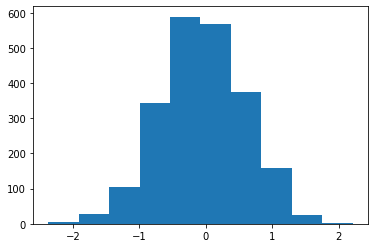

In [38]:
#shows the range of 
plt.hist(prediction_values)

In [ ]:
for stat in ufc_fights.columns:
    print(stat)

In [ ]:
#checking by hand that the accuracy of the manual predictions are the same as the accuracy 
#getting .61 after 100 iterations but .56 after 200 iterations (need longer run)
#.53 after 400 iterations (need longer run)
#.545 for 100 iterations (starting at number 400 so [400:500])
#.62 for 500 iterations (starting at number 500 so [500:1000])
#.607 for 1000 iterations (starting at number 1000 so [1000:2000])
# .58 for 1000 iterations (starting at number 2000 so [2000:3000])


#given by python's model score (around .61 at time of writing... Mar 18 2022)
#takes forever... about 3 seconds per computation
real_values = ufc_fights['result']
is_model_correct=[]
index=0
for i in ufc_fights.index[:10]:
    try:
        index+=1
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        if (manual_prediction(f1,f2,date,date)):
            my_pred = 'W'
        else:
            my_pred = 'L'
        print(f1,f2,my_pred,str(real_values[i]))
        if (my_pred==real_values[i]):
            is_model_correct.append(1)
        else:
            is_model_correct.append(0)
    except:
        continue
    if index>0 and index%10==0:
        manual_accuracy = sum(is_model_correct)/len(is_model_correct)
        print('The accuracy of the model is computed as: '+str(manual_accuracy)+' after '+str(index)+' iterations')
        
        

In [ ]:
#making sure the manual model predictions are as expected
#takes forever... about 3 seconds per computation
real_values = ufc_fights['result']
is_model_correct=[]

for i in ufc_fights.index[:10]:
    try:
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        ufc_predict(f1,f2,date,date)
    except:
        print('this fight didnt compute right')

In [31]:
manual_prediction('Thiago Santos','Magomed Ankalaev', 'March 12, 2022', 'March 12, 2022')

True

In [27]:
ufc_predict('Magomed Ankalaev', 'Thiago Santos','March 12, 2022', 'March 12, 2022')

The winner is...
Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.


In [ ]:
#checking the distribution of the average absolute values of presigmoid values
#this tells us the thresholds for approximating odds (wins out of 10)
#this takes super long... about 3 seconds per computation
#found best bins to be 0, .2, .4, .6, .8, 1, etc going as 5 6 7 8 9 10 times out of 10
prediction_average_absolute_values=[]
for i in ufc_fights_winner.index[:10]:
    try:
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        value1 = presigmoid_value(f1,f2,date,date)
        value2 = presigmoid_value(f2,f1,date,date)
        prediction_average_absolute_values.append((abs(value1)+abs(value2))/2)
    except:
        continue

In [ ]:
bins_for_absavg=[]
for i in range(35):
    bins_for_absavg.append(i/25)
plt.hist(prediction_average_absolute_values, bins=bins_for_absavg)

In [ ]:
def give_odds(fighter1,fighter2,date1,date2):
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    if value-value2>=0:
        winner=fighter1
    else:
        winner=fighter2
    value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    abs_value = (abs(value)+abs(value2))/2
    if abs_value >=0 and abs_value <=.2:
        print(winner+" wins a little over 5 times out of 10 times.")
    elif abs_value >=.2 and abs_value <=.4:
        print(winner+" wins 6 out of 10 times.")
    elif abs_value >=.4 and abs_value <=.6:
        print(winner+" wins 7 out of 10 times.")
    elif abs_value >=.6 and abs_value <=.8:
        print(winner+" wins 9 out of 10 times.")
    elif abs_value >=.8:
        print(winner+" wins 10 out of 10 times.")

In [39]:
winPredictionModel.intercept_[0]

-0.02143379915277674

In [ ]:
#example of finding pre sigmoid value for a fight
b = winPredictionModel.intercept_[0]
value = 0
tup = ufc_prediction_tuple('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')
for i in range(len(tup)):
    value += tup[i]*theta[0][i]
value+b

In [ ]:
give_odds('Colby Covington', 'Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

In [ ]:
#something is serisouly wrong with the model if colby vs jorge gets .126 and jorge vs colby gets -.855
#this needs to be fixed...
v1=presigmoid_value('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')
v2=presigmoid_value('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')
print(v1)
print(v2)
print(abs(v1)+abs(v2)/2)

In [32]:
presigmoid_value('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')

-1.4442878614529782

In [34]:
presigmoid_value('Colby Covington', 'Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

1.4014202631474248

In [ ]:
presigmoid_value('Conor McGregor','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [35]:
presigmoid_value('Khabib Nurmagomedov','Conor McGregor', 'March 5, 2017', 'March 5, 2017')

4.5341081039449715

In [36]:
presigmoid_value('Conor McGregor', 'Khabib Nurmagomedov','March 5, 2017', 'March 5, 2017')

-4.576975702250525

In [ ]:
ufc_predict('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

In [33]:
presigmoid_value('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

2.9035219854370364

In [ ]:
presigmoid_value('Renato Moicano','Rafael Dos Anjos', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Bryce Mitchell', 'Edson Barboza', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Alex Oliveira', 'Kevin Holland','March 5, 2022', 'March 5, 2022',)

In [ ]:
#there must be an issue with the say Spivak's name is scraped. look into this... fix needed
ufc_predict('Sergey Spivak','Greg Hardy', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Jalin Turner','Jamie Mullarkey', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
fighter_height('Yan Xiaonan')

In [ ]:
#issue with unknown reach/height... fix needed
ufc_predict('Marina Rodriguez','Yan Xiaonan', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Nicolae Negumereanu','Kennedy Nzechukwu', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Maryna Moroz','Mariya Agapova', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Umar Nurmagomedov','Brian Kelleher', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Tim Elliott','Tagir Ulanbekov', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
#Must be an issue with michal's name in scraping
ufc_predict('Dustin Jacoby','Michał Oleksiejczuk', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Thiago Santos','Magomed Ankalaev', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Marlon Moraes','Song Yadong', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Sodiq Yusuff','Alex Caceres', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Khalil Rountree Jr.','Karl Roberson', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Drew Dober','Terrance McKinney', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Alex Pereira','Bruno Silva', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Matthew Semelsberger','AJ Fletcher', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('JJ Aldrich','Gillian Robertson', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Trevin Jones','Javid Basharat', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Damon Jackson','Kamuela Kirk', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Sabina Mazo','Miranda Maverick', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Dalcha Lungiambula','Cody Brundage', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Kris Moutinho','Guido Cannetti', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Tafon Nchukwi','Azamat Murzakanov', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict(ufc_fights['fighter'][i],ufc_fights['opponent'][i],ufc_fights['date'][i],ufc_fights['date'][i])

In [ ]:
ufc_predict('Alexander Volkov','Tom Aspinall','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Arnold Allen','Dan Hooker','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Paddy Pimblett','Rodrigo Vargas','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Gunnar Nelson','Takashi Sato','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Molly McCann','Luana Carolina','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Jai Herbert','Ilia Topuria','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Mike Grundy', 'Makwan Amirkhani', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Shamil Abdurakhimov', 'Sergei Pavlovich', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Nikita Krylov', 'Paul Craig', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Jack Shore', 'Timur Valiev', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Cory McKenna', 'Elise Reed', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Nathaniel Wood', 'Vince Morales', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Muhammad Mokaev', 'Cody Durden', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Cody Garbrandt','Raphael Assuncao', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Jon Jones','Jon Jones', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Francis Ngannou','Francis Ngannou', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Randy Couture','Francis Ngannou', 'March 5, 2012', 'March 5, 2022')

In [ ]:
ufc_predict('Roy Nelson','Anthony Johnson', 'March 5, 2012', 'March 5, 2022')

In [ ]:
ufc_prediction_tuple('Khabib Nurmagomedov','Colby Covington', 'March 1, 2022', 'March 1, 2022')

In [ ]:
fighter_reach('Conor McGregor')

In [ ]:
fighter_reach('Colby Covington')

In [ ]:
ufc_predict('Colby Covington','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Khabib Nurmagomedov','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
give_odds('Khabib Nurmagomedov','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
give_odds('Colby Covington','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Khabib Nurmagomedov','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Colby Covington','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [44]:
theta[0]

array([ 0.17859825, -0.35054352,  0.12181295, -0.03852547,  0.02811983,
       -0.09544947, -0.17294226, -0.01178212, -0.04884282, -0.06694046,
       -0.09911792, -0.01679279, -0.05518309,  0.63325912,  0.0178385 ,
       -0.06800284])

In [49]:
import json

theta_values = list(theta[0])
jsonStr = json.dumps(theta_values)
print(jsonStr)

[0.17859825116398007, -0.3505435198180958, 0.12181294852382875, -0.03852546618119, 0.028119831866447478, -0.0954494690106995, -0.17294225897067542, -0.01178211879983269, -0.04884281549938634, -0.06694046241210015, -0.09911791574536293, -0.016792785997147376, -0.05518309320558962, 0.6332591192366879, 0.01783849788772189, -0.06800283810451697]


In [58]:
import json
with open('theta.json', 'w') as outfile:
    json.dump(list(theta[0]), outfile)

In [55]:
b

-0.02143379915277674

In [59]:
import json
with open('intercept.json', 'w') as outfile:
    json.dump(b, outfile)